# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#магическая команда, указывает, что графики нужно строить прямо в ноутбуке: 
%matplotlib inline 

In [215]:
#!pip install comet_ml

In [216]:
from comet_ml import Experiment

In [217]:
experiment = Experiment(
    api_key='RtFHUaHdg6OEV55xJMjkXadEg',
    project_name='predict-income',
    workspace='dmitruy11',
)

COMET WARNING: Not all initial data has been logged for experiment 53cf7251c5a54f0484e3f821725e59d3, call Experiment.end() to ensure that all data to have been logged
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : specific_abbey_6203
COMET INFO:     url                   : https://www.comet.com/dmitruy11/predict-income/53cf7251c5a54f0484e3f821725e59d3
COMET INFO:   Metrics:
COMET INFO:     Accuracy OneHot data : 0.8044466281783564
COMET INFO:     roc_auc OneHot data  : 0.785
COMET INFO:   Parameters:
COMET INFO:     C                     : 1.0
COMET INFO:     categories            : auto
COMET INFO:     class_weight          : None
COMET INFO:     drop                  : None
COMET INFO:     dtyp

## Загрузка данных

In [218]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [219]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


Проверим размерности наших файлов:

In [220]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [221]:
target_name = 'income'

In [222]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [223]:
y_train.value_counts(normalize=True)

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [224]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


{'web': 'https://www.comet.com/api/image/download?imageId=751e24684d5b458f878b86c1100bde04&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=751e24684d5b458f878b86c1100bde04&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'imageId': '751e24684d5b458f878b86c1100bde04'}

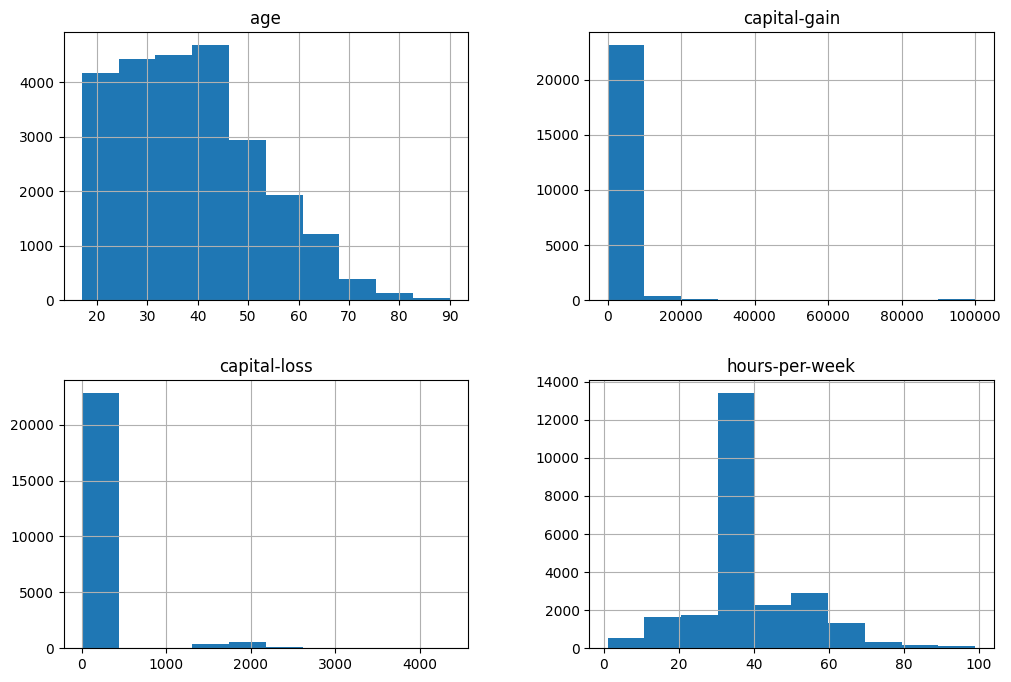

In [225]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [226]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [227]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [228]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [229]:
X_train['workclass'].value_counts(True).head(1)

workclass
Private    0.696766
Name: proportion, dtype: float64

In [230]:
X_train['education'].value_counts(True).head(1)

education
HS-grad    0.322484
Name: proportion, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [231]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [232]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [233]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [234]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [235]:
from sklearn.preprocessing import LabelEncoder

In [236]:
label_encoder = LabelEncoder()

In [237]:
X_train_le = X_train.copy()

In [238]:
X_test_le = X_test.copy()

In [239]:
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [240]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


**One Hot Encoding**



In [241]:
from sklearn.preprocessing import OneHotEncoder

In [242]:
onehot_encoder = OneHotEncoder()

In [243]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [244]:
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [245]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [246]:
X_train_new

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,47,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24416,31,0.0,0.0,21,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24417,18,0.0,0.0,20,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24418,50,0.0,0.0,84,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [247]:
X_test_new 

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,27,0.0,0.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,45,0.0,0.0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29,0.0,0.0,55,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,29,2202.0,0.0,50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8137,60,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8138,25,0.0,0.0,40,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8139,50,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [248]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [249]:
linear_model_oh = LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [250]:
linear_model_oh.fit(X_train_new, y_train)

C:\Users\Дмитрий\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [251]:
linear_model_oh.fit(X_train_le, y_train)

C:\Users\Дмитрий\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Валидация модели на тестовой выборке

In [252]:
prediction_oh = linear_model_oh.predict(X_test_le )

In [253]:
prediction_le=linear_model_oh.predict(X_test_le )

In [254]:
X_test_le

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,4,15,0,1,1,4,0,0.0,0.0,38,39
1,45,7,11,2,4,5,4,0,0.0,0.0,40,39
2,29,4,9,2,4,0,2,1,0.0,0.0,55,39
3,30,4,9,4,7,1,4,0,0.0,0.0,40,39
4,29,6,15,0,3,1,4,1,2202.0,0.0,50,39
...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,4,11,5,8,1,2,1,0.0,0.0,40,39
8137,60,4,4,2,12,0,4,1,0.0,0.0,40,0
8138,25,0,11,4,0,4,2,0,0.0,0.0,40,39
8139,50,4,9,2,12,0,4,1,0.0,0.0,40,39


In [255]:
np.unique(prediction_oh)

array([0, 1], dtype=int64)

In [256]:
# Сколько 1го класса присутсвует в предсказаниях?
# Предсказание на тренировочных данных
sum(prediction_oh)/len(prediction_oh)

0.09888220120378331

In [257]:


# Посчитать уникальные значения в предсказаниях
unique_values, counts = np.unique(prediction_oh, return_counts=True)

# Найти количество примеров 1-го класса
num_class_1 = counts[np.where(unique_values == 1)[0][0]]

print(f"Количество примеров 1-го класса в предсказаниях: {num_class_1}")

Количество примеров 1-го класса в предсказаниях: 805


In [258]:
# Сколько 1го класса присутсвует в y_test?
# Подсчет количества примеров 1-го класса в y_test
sum(y_test)/len(y_test)

0.23670310772632355

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [259]:
from sklearn.metrics import accuracy_score

In [260]:
acc_oh = accuracy_score(y_test, prediction_oh)

In [261]:
acc_oh

0.8044466281783564

In [262]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [263]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [264]:
# Залогировать accuracy для LE
acc_le=accuracy_score(y_test, prediction_le)

In [265]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [266]:
from sklearn.metrics import confusion_matrix

In [267]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5979,235
1,1357,570


In [268]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'web': 'https://www.comet.com/api/asset/download?assetId=ed49700bb424442ab33ae94c9b98f517&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=ed49700bb424442ab33ae94c9b98f517&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'assetId': 'ed49700bb424442ab33ae94c9b98f517'}

## Прогноз вероятности принадлежности к классу

In [269]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_le )

In [270]:
# Как выглядят предсказания?
pred_proba_oh 

array([[0.74337981, 0.25662019],
       [0.9605037 , 0.0394963 ],
       [0.68440827, 0.31559173],
       ...,
       [0.9465686 , 0.0534314 ],
       [0.67286508, 0.32713492],
       [0.45143632, 0.54856368]])

In [271]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'web': 'https://www.comet.com/api/image/download?imageId=637ee31432764855834fa8f3b4694bac&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=637ee31432764855834fa8f3b4694bac&experimentKey=831d8a4fd9a74988a6422c6cbd715aec',
 'imageId': '637ee31432764855834fa8f3b4694bac'}

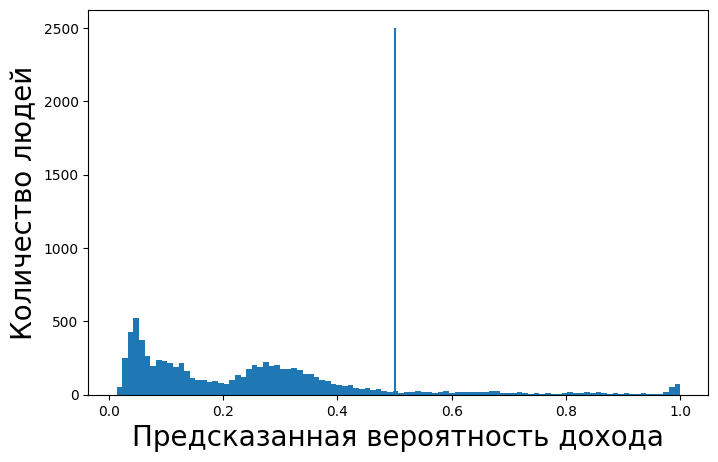

In [272]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [273]:
from sklearn.metrics import roc_curve

In [274]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

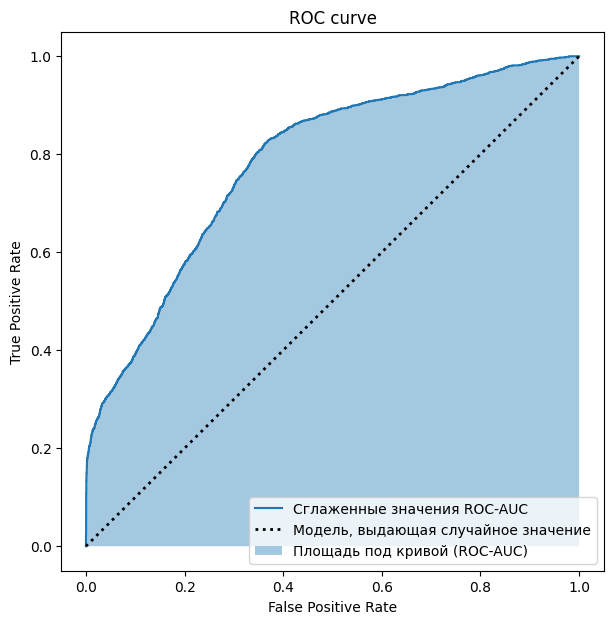

In [275]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [276]:
from sklearn.metrics import roc_auc_score

In [277]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [278]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.785


In [279]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [280]:
pred_proba_le = linear_model_oh.predict_proba(X_test_le )

In [281]:
pred_proba = pred_proba_le[:, 1]

In [282]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc

0.785

In [283]:
experiment.display()